# Analyze the data to evaluate the relative performance of different gene weighting methods

In [1]:
%load_ext lab_black

import pandas as pd
import itertools
import numpy as np
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import scdrs
from scipy.stats import ttest_ind
from os.path import join

In [2]:
df_trait_info = pd.read_excel("../supp_tables.xlsx", sheet_name=0).set_index(
    "Trait_Identifier"
)
DATA_PATH = "/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data"
data_facs_ct = scdrs.data_loader.load_tms_ct(DATA_PATH, data_name="facs")
df_celltype = data_facs_ct.obs.cell_ontology_class.str.replace(" ", "_").str.replace(
    ",", ""
)

# parse control trait - celltype pairs
df_control = pd.read_excel("control_disease_celltype.xlsx", index_col=0)

dict_control_pairs = {}
for trait, row in df_control.iterrows():
    # positive cells
    positive_cells = df_celltype.index[df_celltype.isin(row.iloc[0].split(";"))]
    # negative cells
    negative_cells = df_celltype.index[df_celltype.isin(row.iloc[1].split(";"))]
    assert set(df_celltype[positive_cells].values) == set(row.iloc[0].split(";"))
    assert set(df_celltype[negative_cells].values) == set(row.iloc[1].split(";"))
    print(f"{trait}: {len(positive_cells)}, {len(negative_cells)}")
    dict_control_pairs[trait] = [positive_cells, negative_cells]

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


UKB_460K.blood_RBC_DISTRIB_WIDTH: 187, 275
UKB_460K.blood_MONOCYTE_COUNT: 2659, 275
PASS_Rheumatoid_Arthritis: 4145, 1162
PASS_IBD_deLange2017: 4145, 1162
UKB_460K.disease_ASTHMA_DIAGNOSED: 4145, 1162
UKB_460K.disease_HYPOTHYROIDISM_SELF_REP: 4145, 1162
UKB_460K.cov_SMOKING_STATUS: 827, 4145
PASS_Schizophrenia_Pardinas2018: 827, 4145
PASS_MDD_Howard2019: 827, 4145
UKB_460K.cov_EDU_COLLEGE: 827, 4145
UKB_460K.biochemistry_Triglycerides: 1162, 827
UKB_460K.biochemistry_Cholesterol: 1162, 827
UKB_460K.biochemistry_HDLcholesterol: 1162, 827
UKB_460K.biochemistry_Testosterone_Male: 1162, 827
UKB_460K.body_HEIGHTz: 275, 827
UKB_460K.bmd_HEEL_TSCOREz: 275, 827
PASS_FastingGlucose_Manning: 1342, 827
PASS_Type_2_Diabetes: 1342, 827
PASS_AtrialFibrillation_Nielsen2018: 550, 827
UKB_460K.bp_SYSTOLICadjMEDz: 550, 827


In [62]:
# # construct control cell-types

# brain_neuron_cells = data_facs_ct.obs.cell_ontology_class.str.contains("neuron")
# heart_myocyte_cells = data_facs_ct.obs.cell_ontology_class.str.contains("myocyte") & (
#     data_facs_ct.obs.tissue == "Heart"
# )
# marrow_monocyte_cells = data_facs_ct.obs.cell_ontology_class.str.contains(
#     "monocyte"
# ) & (data_facs_ct.obs.tissue == "Marrow")

# t_cells = data_facs_ct.obs.cell_ontology_class.str.contains("T cell")
# hepatocyte_cells = data_facs_ct.obs.cell_ontology_class.str.contains("hepatocyte")


# positive_pairs = {
#     "PASS_Schizophrenia_Pardinas2018": data_facs_ct.obs.index[brain_neuron_cells],
#     "PASS_MDD_Howard2019": data_facs_ct.obs.index[brain_neuron_cells],
#     "PASS_AtrialFibrillation_Nielsen2018": data_facs_ct.obs.index[heart_myocyte_cells],
#     "PASS_Rheumatoid_Arthritis": data_facs_ct.obs.index[t_cells],
#     "UKB_460K.biochemistry_LDLdirect": data_facs_ct.obs.index[hepatocyte_cells],
# }

# negative_pairs = {
#     "PASS_Schizophrenia_Pardinas2018": data_facs_ct.obs.index[t_cells],
#     "PASS_MDD_Howard2019": data_facs_ct.obs.index[t_cells],
#     "PASS_AtrialFibrillation_Nielsen2018": data_facs_ct.obs.index[brain_neuron_cells],
#     "PASS_Rheumatoid_Arthritis": data_facs_ct.obs.index[hepatocyte_cells],
#     "UKB_460K.biochemistry_LDLdirect": data_facs_ct.obs.index[brain_neuron_cells],
# }
# trait_list = list(positive_pairs.keys())
# dict_control_pairs = {
#     trait: [positive_pairs[trait], negative_pairs[trait]] for trait in trait_list
# }

In [3]:
gwas_weight_list = (
    [f"top-{n}" for n in [100, 500, 1000, 2000]]
    + [f"fwer5-{n}" for n in [1000, 2000]]
    + [f"fdr1-{n}" for n in [1000, 2000]]
    + [f"fdr5-{n}" for n in [1000, 2000]]
)
gwas_weight_list = [
    f"{m}-{w}" for m, w in itertools.product(gwas_weight_list, ["zscore", "uniform"])
]
method_list = [
    f"{m}.{w}" for m, w in itertools.product(gwas_weight_list, ["uniform", "vs"])
]

In [4]:
SCORE_ROOT_DIR = (
    "/n/holyscratch01/price_lab/khou/continuous_weights_experiment/score_file"
)


def summarize(method):
    df_plot = {
        "method": [],
        "trait": [],
        "rep_i": [],
        "n_pos": [],
        "n_neg": [],
        "n_discovery": [],
        "tstats": [],
        "meanshift": [],
    }
    rep_i = 0
    for trait in tqdm(dict_control_pairs):
        for rep_i in range(20):
            # load score
            df_score = pd.read_csv(
                join(SCORE_ROOT_DIR, f"rep{rep_i}/{method}/{trait}.score.gz"),
                sep="\t",
                index_col=0,
            )
            df_score["fdr"] = multipletests(df_score["pval"], method="fdr_bh")[1]

            # find positive cells and negative cells
            positive_cells = df_score.index.isin(dict_control_pairs[trait][0])
            negative_cells = df_score.index.isin(dict_control_pairs[trait][1])

            # compute stats and fill in values
            df_plot["method"].append(method)
            df_plot["trait"].append(trait)
            df_plot["n_pos"].append(sum(positive_cells))
            df_plot["n_neg"].append(sum(negative_cells))
            df_plot["rep_i"].append(rep_i)
            df_plot["tstats"].append(
                ttest_ind(
                    df_score["zscore"][positive_cells],
                    df_score["zscore"][negative_cells],
                    equal_var=False,
                )[0]
            )

            df_plot["meanshift"].append(
                df_score["zscore"][positive_cells].mean()
                - df_score["zscore"][negative_cells].mean()
            )

            df_plot["n_discovery"].append(np.sum(df_score["fdr"] < 0.1))

    return pd.DataFrame(df_plot)

In [46]:
import submitit

executor = submitit.AutoExecutor(folder="~/submitit/")
executor.update_parameters(timeout_min=10, mem_gb=12, slurm_partition="shared")

jobs = executor.map_array(
    summarize,
    method_list,
)
df_plot = pd.concat(j.result() for j in jobs)
df_plot.to_csv("tstats-analysis.csv", index=False)

In [40]:
df_plot = pd.read_csv("tstats-analysis.csv")

# normalize by the trait, rep_i max
df_plot_normalized = []
for (trait, rep_i), df_group in df_plot.groupby(["trait", "rep_i"]):
    for col in ["n_discovery", "tstats", "meanshift"]:
        df_group[col] /= df_group[col].max()
    df_plot_normalized.append(df_group)
df_plot_normalized = pd.concat(df_plot_normalized)

df_plot = df_plot_normalized.groupby(["method", "rep_i"]).mean().reset_index()

In [41]:
df_plot["gwas_weight"] = df_plot["method"].apply(lambda x: x.split(".")[0])
df_plot["sc_weight"] = df_plot["method"].apply(lambda x: x.split(".")[1])

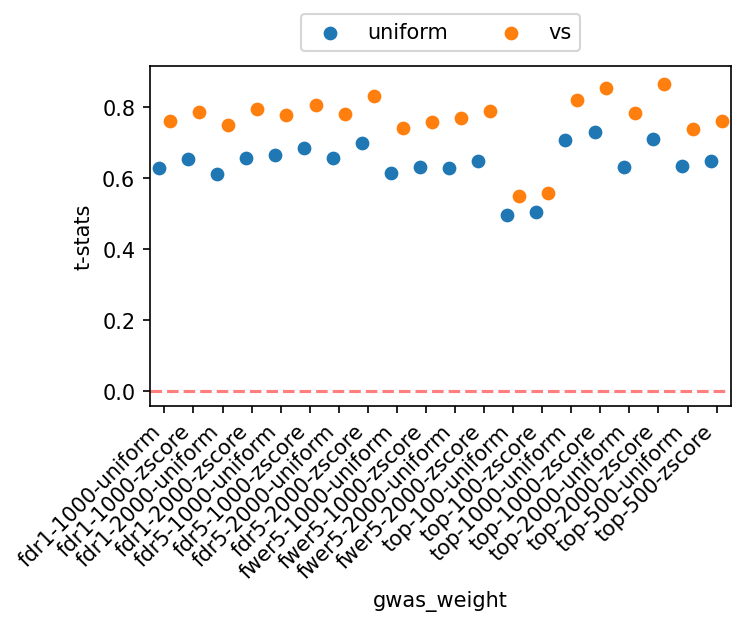

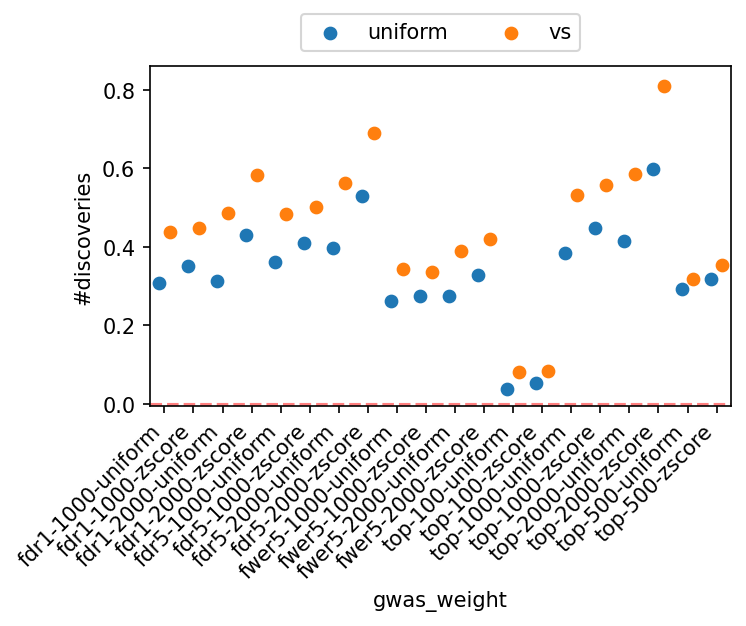

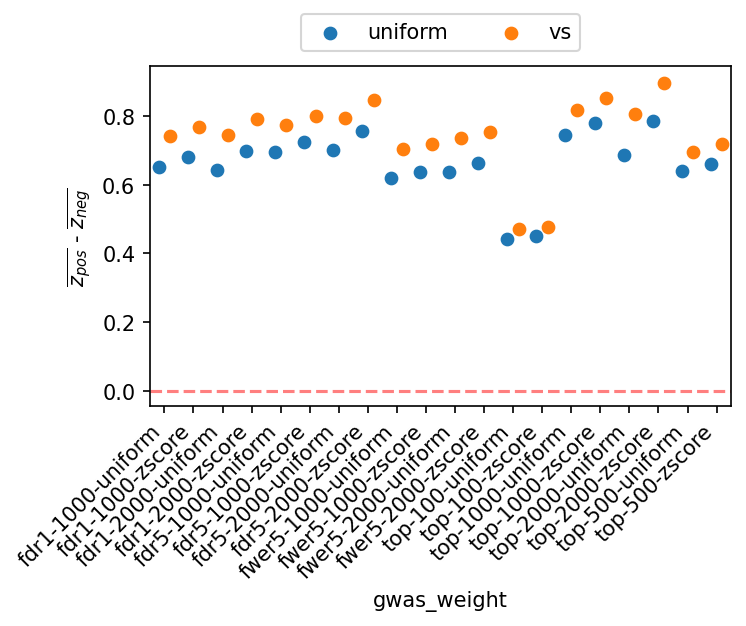

In [42]:
for y in ["tstats", "n_discovery", "meanshift"]:
    fig, ax = plt.subplots(figsize=(5, 3), dpi=150)
    sns.pointplot(
        data=df_plot,
        x="gwas_weight",
        y=y,
        hue="sc_weight",
        errwidth=0.75,
        join=False,
        scale=0.75,
        dodge=0.4,
        ax=ax,
    )
    ax.legend(loc="center", bbox_to_anchor=[0.5, 1.1], ncol=2)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    if y == "tstats":
        ax.set_ylabel("t-stats")
    elif y == "n_discovery":
        ax.set_ylabel("#discoveries")
    elif y == "meanshift":
        ax.set_ylabel("$\\overline{z_{pos}}$ - $\\overline{z_{neg}}$")
    else:
        raise NotImplementedError
    ax.axhline(y=0, ls="--", color="red", alpha=0.5)

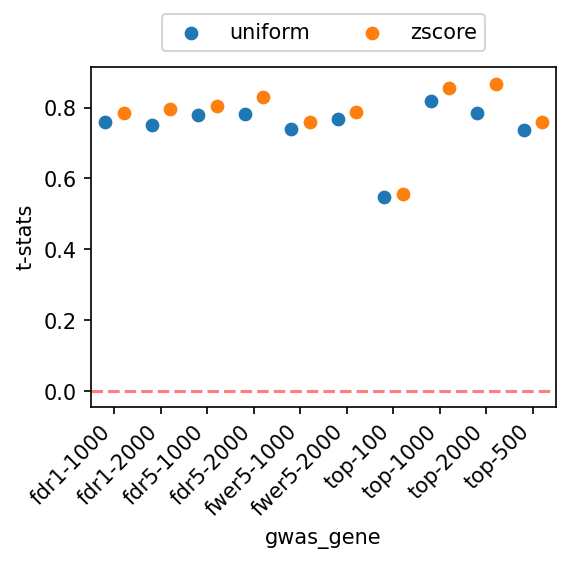

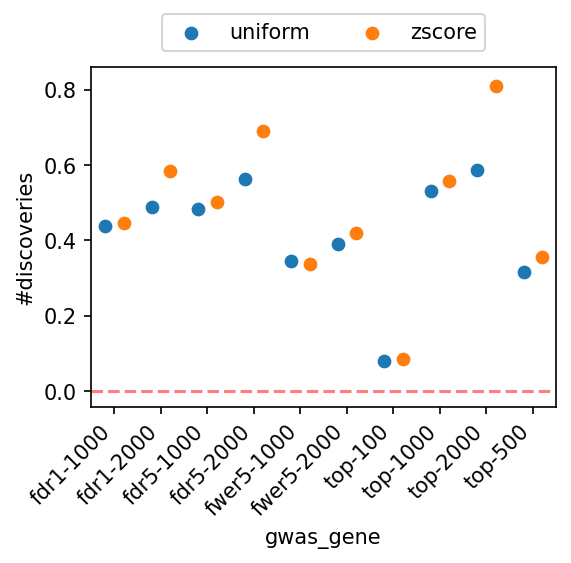

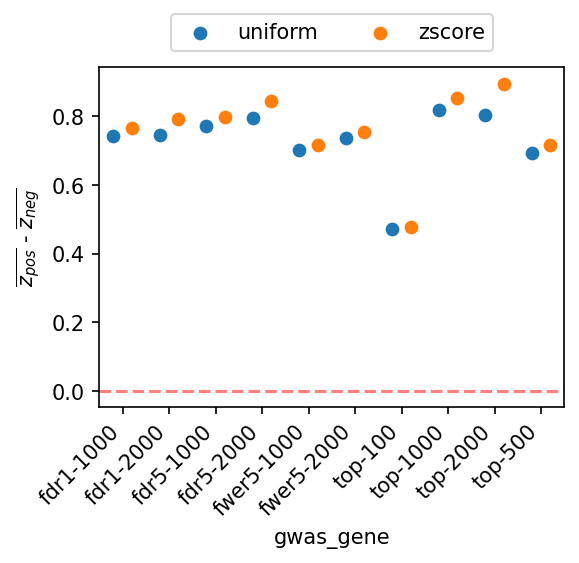

In [43]:
for y in ["tstats", "n_discovery", "meanshift"]:
    df_tmp = df_plot[df_plot.sc_weight == "vs"].drop(columns=["sc_weight"])
    df_tmp["gwas_gene"] = df_tmp["gwas_weight"].apply(lambda x: x.rsplit("-", 1)[0])
    df_tmp["gwas_gene_weight"] = df_tmp["gwas_weight"].apply(
        lambda x: x.rsplit("-", 1)[1]
    )

    fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
    sns.pointplot(
        data=df_tmp,
        x="gwas_gene",
        y=y,
        hue="gwas_gene_weight",
        errwidth=0.75,
        join=False,
        scale=0.75,
        dodge=0.4,
        ax=ax,
    )
    ax.legend(loc="center", bbox_to_anchor=[0.5, 1.1], ncol=2)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    if y == "tstats":
        ax.set_ylabel("t-stats")
    elif y == "n_discovery":
        ax.set_ylabel("#discoveries")
    elif y == "meanshift":
        ax.set_ylabel("$\\overline{z_{pos}}$ - $\\overline{z_{neg}}$")
    else:
        raise NotImplementedError
    ax.axhline(y=0, ls="--", color="red", alpha=0.5)

Therefore, we consistently use "vs" weighting for now

# Numerical results

In [9]:
df_plot = df_plot[df_plot.sc_weight == "vs"].drop(columns=["sc_weight"])

# trait-specific maximum

dict_max_n_discovery = (
    df_plot.groupby("trait").apply(lambda x: np.max(x["n_discovery"])).to_dict()
)
df_plot["normalized_n_discovery"] = df_plot.apply(
    lambda x: x["n_discovery"] / dict_max_n_discovery[x.trait], axis=1
)

dict_max_tstats = (
    df_plot.groupby("trait").apply(lambda x: np.max(x["tstats"])).to_dict()
)
df_plot["normalized_tstats"] = df_plot.apply(
    lambda x: x["tstats"] / dict_max_tstats[x.trait], axis=1
)


dict_max_meanshift = (
    df_plot.groupby("trait").apply(lambda x: np.max(x["meanshift"])).to_dict()
)
df_plot["normalized_meanshift"] = df_plot.apply(
    lambda x: x["meanshift"] / dict_max_meanshift[x.trait], axis=1
)

In [10]:
df_plot_avg = df_plot.groupby("gwas_weight").mean().loc[gwas_weight_list]

In [12]:
from scipy.stats import pearsonr, spearmanr

df_plot = {"method": [], "trait": [], "n_discovery": []}

for trait in trait_list:
    # for trait in df_trait_info.index:
    dict_df_score = {}
    for w in ["top-1000-uniform", "top-1000-zscore"]:
        df_score = pd.read_csv(
            f"tms_facs/score_file/{w}.vs/{trait}.score.gz",
            sep="\t",
            index_col=0,
        )
        df_score["fdr"] = multipletests(df_score["pval"], method="fdr_bh")[1]
        dict_df_score[w] = df_score
    print(
        trait,
        pearsonr(
            dict_df_score["top-1000-uniform"].zscore,
            dict_df_score["top-1000-zscore"].zscore,
        )[0],
    )

PASS_Schizophrenia_Pardinas2018 0.9859760479978108
PASS_MDD_Howard2019 0.986197294363645
PASS_AtrialFibrillation_Nielsen2018 0.9619784204619377
PASS_Rheumatoid_Arthritis 0.975524836764889
UKB_460K.biochemistry_LDLdirect 0.976120990430571
